In [2]:
%run /Users/mjymjy007/Documents/GitHub/data-science-spring-2025/01_introduction/work/Data_cleaning.ipynb

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [7]:
from datetime import datetime
def ensure_am_pm(time_str):
    time_str = time_str.strip()
    if 'am' in time_str.lower() or 'pm' in time_str.lower():
        return time_str.upper()
    if ':' in time_str:
        return time_str + 'AM'  # assume morning
    elif time_str.isdigit():
        return time_str + 'AM'  # assume morning
    return time_str

# Parse a single time range (e.g. '11:30AM-3PM')
def get_hours_from_range(time_range):
    start, end = time_range.split('-')

    start = ensure_am_pm(start)
    end = ensure_am_pm(end)

    # Parse with or without minutes
    try:
        start_dt = datetime.strptime(start, '%I:%M%p')
    except ValueError:
        start_dt = datetime.strptime(start, '%I%p')

    try:
        end_dt = datetime.strptime(end, '%I:%M%p')
    except ValueError:
        end_dt = datetime.strptime(end, '%I%p')

    duration = (end_dt - start_dt).seconds / 3600
    return duration

# Parse a full day's schedule (e.g. '11:30AM-3PM,5-10PM')
def calculate_operating_hours(day_schedule):
    if not isinstance(day_schedule, str):
        return 0.0
    day_schedule = day_schedule.strip().lower()

    if 'closed' in day_schedule:
        return 0.0
    if 'open 24 hours' in day_schedule:
        return 24.0

    total = 0.0
    for time_range in day_schedule.split(','):
        time_range = time_range.strip()
        if not time_range or 'open 24 hours' in time_range:
            continue
        try:
            total += get_hours_from_range(time_range)
        except Exception as e:
            print(f"Error parsing time '{time_range}': {e}")
    return total

# Parse a full week (e.g. 'Monday:10AM-9PM|Tuesday:Closed|...')
def calculate_total_operating_time(schedule_str):
    if not isinstance(schedule_str, str):
        return 0.0

    total_hours = 0.0
    for day in schedule_str.split('|'):
        if ':' not in day:
            continue
        day_name, day_schedule = day.split(':', 1)
        total_hours += calculate_operating_hours(day_schedule)
    return total_hours

df['time'] = df['working_hours_old_format'].apply(calculate_total_operating_time)
df.loc[df['time'] == 0, 'time'] = df['time'].median()

In [8]:
df = df.loc[df.reviews >= 50] #we want to consider number f reviews as a factor and thus drop those without enough reviews

In [9]:
df = df[~df['name'].str.contains('truck', case=False, na=False)]# drop the food trucks

In [10]:
from geopy.distance import geodesic
city_center_coords = (39.9526, -75.1652)  # (lat, lon)

# Compute distance to City Hall and create new feature column
df['city_hall_distance_km'] = df.apply(
    lambda row: geodesic(city_center_coords, (row['latitude'], row['longitude'])).kilometers,
    axis=1
)

In [11]:
#it took a while to get the data, so we saved it and now load it
#there are some missing stops, so we add them manually
df_stops_unique=pd.read_csv('../../data/philly_trolley_stops.csv')
new_coords = [
    (39.963076, -75.259995),
    (39.9644, -75.2523),
    (39.9627, -75.2468),
    (39.9619, -75.2408),
    (39.9608, -75.233),
    (39.9597, -75.225),
    (39.9585, -75.2141),
    (39.957, -75.202),
    (39.95575, -75.19132),
    (39.955, -75.1835),
    (39.955, -75.1835),  # duplicate — will be removed
    (39.951944, -75.161389),
    (39.952076, -75.156612),
    (39.952076, -75.156612),  # duplicate — will be removed
    (39.9505, -75.1488),
    (39.9498, -75.1436),
    (39.9606, -75.1404),
    (39.9689, -75.1362),
    (39.9787, -75.1335),
    (39.9851, -75.1322),
    (39.9888, -75.1273),
    (39.9916, -75.1222),
    (39.9965, -75.1135),
    (40.0003, -75.1065),
    (40.006, -75.0961),
    (40.0107, -75.0889),
    (40.0162, -75.0842),
    (40.023333, -75.076944),
]

# Convert to DataFrame
df_new = pd.DataFrame(new_coords, columns=["location_lat", "location_lon"])

# Append and drop duplicates
df_stops_unique = pd.concat([df_stops_unique, df_new], ignore_index=True).drop_duplicates().reset_index(drop=True)

In [12]:
trolley_coords = list(zip(df_stops_unique.location_lat, df_stops_unique.location_lon))  # (latitude, longitude)

def min_distance_to_trolley(row):
    point = (row['latitude'], row['longitude'])
    distances = [geodesic(point, trolley).km for trolley in trolley_coords]
    return min(distances)

df['trolley_distance_km'] = df.apply(min_distance_to_trolley, axis=1)

In [13]:
all_features=['time','reviews','trolley_distance_km','city_hall_distance_km','price']

In [14]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
category_dummies = pd.get_dummies(df['category'], prefix='category',drop_first=True)*1.0
df = pd.concat([df, category_dummies], axis=1)


In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import make_scorer, mean_squared_error

In [16]:
df['median_income'] = pd.to_numeric(df['median_income'], errors='coerce')

# Identify invalid (NaN) indices
invalid_indices = df[df['median_income'].isna()].index

# Filter valid rows
valid_rows = df[df['median_income'].notna()].copy()
# Loop through invalid entries
for i in invalid_indices:
    current_loc = (df.loc[i, 'latitude'], df.loc[i, 'longitude'])

    # Compute distances to all valid points
    valid_rows['distance'] = valid_rows.apply(
        lambda row: geodesic(current_loc, (row['latitude'], row['longitude'])).km,
        axis=1
    )

    # Find 3 nearest neighbors
    nearest_3 = valid_rows.nsmallest(3, 'distance')
    replacement_value = nearest_3['median_income'].mean()

    # Replace the missing value
    df.at[i, 'median_income'] = replacement_value

In [17]:
df['population'] = pd.to_numeric(df['population'], errors='coerce')

# Identify invalid (NaN) indices
invalid_indices = df[df['population'].isna()].index

# Filter valid rows
valid_rows = df[df['population'].notna()].copy()

# Loop through invalid entries
for i in invalid_indices:
    current_loc = (df.loc[i, 'latitude'], df.loc[i, 'longitude'])

    # Compute distances to all valid points
    valid_rows['distance'] = valid_rows.apply(
        lambda row: geodesic(current_loc, (row['latitude'], row['longitude'])).km,
        axis=1
    )

    # Find 3 nearest neighbors
    nearest_3 = valid_rows.nsmallest(3, 'distance')
    replacement_value = nearest_3['population'].mean()

    # Replace the missing value
    df.at[i, 'population'] = replacement_value

In [18]:
df_train,df_test=train_test_split(df,test_size=.2,random_state=42)

In [19]:
X_raw = df_train[all_features].copy()
y = df_train['rating']

# Square root transformation (clip negatives)
X_sqrt = np.sqrt(X_raw.clip(lower=0))
X_sqrt.columns = [f'sqrt_{col}' for col in X_sqrt.columns]

# Polynomial degree-2 features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = pd.DataFrame(poly.fit_transform(X_raw), columns=poly.get_feature_names_out(all_features))

# Combine polynomial + sqrt
X_combined = pd.concat([X_poly.reset_index(drop=True), X_sqrt.reset_index(drop=True)], axis=1)
rf= RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_combined,y)

RandomForestRegressor(random_state=42)

In [20]:
X = df[all_features].copy()
y = df['rating']

# Square root features
X_sqrt = np.sqrt(X.clip(lower=0))
X_sqrt.columns = [f'sqrt_{col}' for col in X_sqrt.columns]

# Polynomial features
X_poly = pd.DataFrame(poly.transform(X), columns=poly.get_feature_names_out(all_features))

# Combine features
X_combined = pd.concat([X_poly.reset_index(drop=True), X_sqrt.reset_index(drop=True)], axis=1)

# Predict
y_pred = rf.predict(X_combined)
df_result = df.copy()
df_result['predicted_rating'] = y_pred
df_result['residual'] = df_result['rating'] - df_result['predicted_rating']
df_result['residual'] = pd.to_numeric(df_result['residual'], errors='coerce')
# Classify based on whether actual > predicted
df_result['class'] = np.where(df_result['residual'] > 0, 'upper', 'lower')

# Split into upper and lower groups
upper_class = df_result[df_result['class'] == 'upper']
lower_class = df_result[df_result['class'] == 'lower']

# Optional: Check sizes or preview
print(f"Upper class count: {len(upper_class)}")
print(f"Lower class count: {len(lower_class)}")

Upper class count: 1534
Lower class count: 1251


In [21]:
# First, store the max residual value
max_residual = df_result['residual'].max()

# Then filter the dataframe for the row(s) with that value
df_result.loc[df_result['residual'] == max_residual]

,query,name,name_for_emails,site,subtypes,category,type,phone,full_address,borough,...,category_Latin American and Caribbean food,category_Middle Eastern food,category_Other / uncategorized,category_Seafood,category_Specialty or ethnic,category_Vegan and healthy food,category_other,predicted_rating,residual,class
2217,"restaurant, 19123, Philadelphia, PA, US",Saffron Indian Kitchen,Saffron Indian Kitchen,https://saffronofphilly.com/saffron-philly,Indian restaurant,Indian food,Indian restaurant,+1 215-964-9223,"423 W Girard Ave, Philadelphia, PA 19123",Olde Kensington,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.668,1.032,upper


In [22]:
# First, store the min residual value
min_residual = df_result['residual'].min()

# Then filter the dataframe for the row(s) with that value
df_result.loc[df_result['residual'] == min_residual]

,query,name,name_for_emails,site,subtypes,category,type,phone,full_address,borough,...,category_Latin American and Caribbean food,category_Middle Eastern food,category_Other / uncategorized,category_Seafood,category_Specialty or ethnic,category_Vegan and healthy food,category_other,predicted_rating,residual,class
2758,"restaurant, 19132, Philadelphia, PA, US",Domino's Pizza,Dominos Pizza,https://www.dominos.com/en/?utm_source=google,"Pizza delivery, Chicken wings restaurant, Pizz...",Fast food,Pizza delivery,+1 215-225-2272,"2701 N Broad St, Philadelphia, PA 19132",North Philadelphia East,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.867,-1.667,lower


In [ ]:
from statsmodels.miscmodels.ordinal_model import OrderedModel
category_cols = [col for col in df_train.columns if col.startswith('category_')]
X = df_train[['median_income'] + category_cols]
y = df_train['price']

# Create and fit the model
model = OrderedModel(y, X, distr='logit')  # or 'probit'
res = model.fit(method='bfgs')
print(res.summary())

# Predict expected value of PRICE
pred_probs = res.predict()
df_train['predicted_price'] = pred_probs @ np.array([1, 2, 3, 4])

         Current function value: 0.743620
         Iterations: 165
         Function evaluations: 221
         Gradient evaluations: 209
                             OrderedModel Results                             
Dep. Variable:                  price   Log-Likelihood:                -1656.8
Model:                   OrderedModel   AIC:                             3352.
Method:            Maximum Likelihood   BIC:                             3460.
Date:                Mon, 21 Apr 2025                                         
Time:                        14:32:53                                         
No. Observations:                2228                                         
Df Residuals:                    2209                                         
Df Model:                          16                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

In [24]:
correlation = df_train['price'].corr(df_train['predicted_price'])
print("Correlation:", correlation)

Correlation: 0.32717719052874267


In [25]:
category_cols = [col for col in df.columns if col.startswith('category_')]
pred_probs = res.predict(df[['median_income'] + category_cols])
df['predicted_price'] = pred_probs @ np.array([1, 2, 3, 4])

In [28]:
pred_probs = res.predict(df[['median_income'] + category_cols])
df_test['predicted_price'] = pred_probs @ np.array([1, 2, 3, 4])

In [29]:
df_test['predicted_price'].corr(df_test['price'])

np.float64(0.37213948897608085)

In [30]:
all_features=['time','reviews','trolley_distance_km','city_hall_distance_km','predicted_price','population','median_income']

In [31]:
rf=RandomForestRegressor(n_estimators=100, random_state=42)
y=df_train['rating']
rf.fit(df_train[all_features],y)

RandomForestRegressor(random_state=42)

                 Feature  Importance
4        predicted_price    0.213040
3  city_hall_distance_km    0.192923
0                   time    0.152203
1                reviews    0.142889
2    trolley_distance_km    0.129231
6          median_income    0.088032
5             population    0.081682


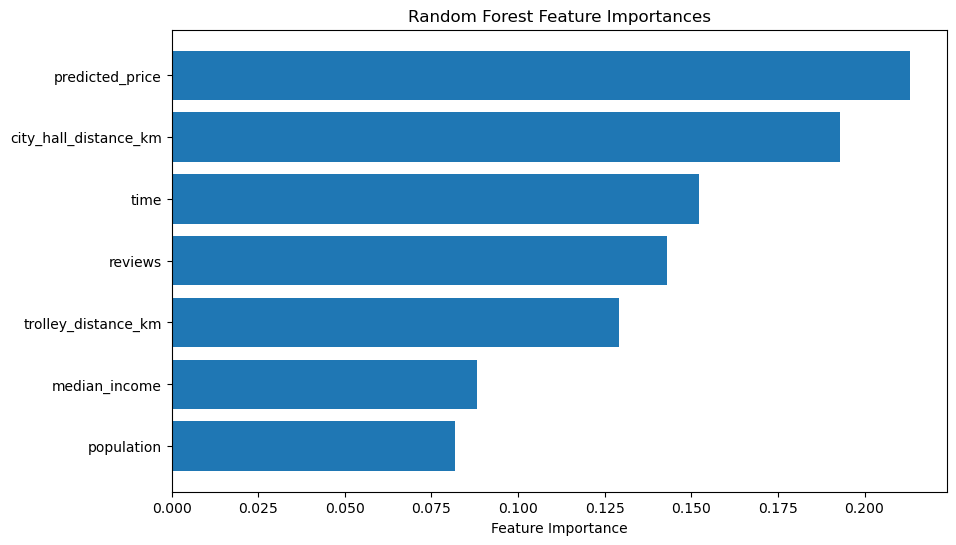

In [32]:
importances = rf.feature_importances_
feature_names = df_train[all_features].columns

# Create a DataFrame for easier viewing
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Optional: plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.show()

In [33]:
mean_squared_error(rf.predict(df_test[all_features]),df_test['rating'])

0.17131376840215437

In [34]:
y_pred = rf.predict(df[all_features])
df_result = df.copy()
df_result['predicted_rating'] = y_pred
df_result['residual'] = df_result['rating'] - df_result['predicted_rating']
df_result['residual'] = pd.to_numeric(df_result['residual'], errors='coerce')
# Classify based on whether actual > predicted
df_result['class'] = np.where(df_result['residual'] > 0, 'upper', 'lower')

# Split into upper and lower groups
upper_class = df_result[df_result['class'] == 'upper']
lower_class = df_result[df_result['class'] == 'lower']

# Optional: Check sizes or preview
print(f"Upper class count: {len(upper_class)}")
print(f"Lower class count: {len(lower_class)}")

Upper class count: 1553
Lower class count: 1232


In [35]:
# First, store the max residual value
max_residual = df_result['residual'].max()

# Then filter the dataframe for the row(s) with that value
df_result.loc[df_result['residual'] == max_residual]

,query,name,name_for_emails,site,subtypes,category,type,phone,full_address,borough,...,category_Middle Eastern food,category_Other / uncategorized,category_Seafood,category_Specialty or ethnic,category_Vegan and healthy food,category_other,predicted_price,predicted_rating,residual,class
3484,"restaurant, 19144, Philadelphia, PA, US",Hot Clucks,Hot Clucks,https://hotclucks.com/,Takeout Restaurant,Fast food,Takeout Restaurant,+1 267-297-7542,"10 W Chelten Ave, Philadelphia, PA 19144",Germantown,...,0.0,0.0,0.0,0.0,0.0,0.0,1.411931,3.565,1.135,upper


In [36]:
# First, store the min residual value
min_residual = df_result['residual'].min()

# Then filter the dataframe for the row(s) with that value
df_result.loc[df_result['residual'] == min_residual]

,query,name,name_for_emails,site,subtypes,category,type,phone,full_address,borough,...,category_Middle Eastern food,category_Other / uncategorized,category_Seafood,category_Specialty or ethnic,category_Vegan and healthy food,category_other,predicted_price,predicted_rating,residual,class
611,"restaurant, 19153, Philadelphia, PA, US",Geno's Steaks,Genos Steaks,NaN,"Cheesesteak restaurant, Takeout Restaurant",Drinks and bars,Cheesesteak restaurant,+1 215-492-9400,"8000 Essington Ave, Philadelphia, PA 19153",Southwest Philadelphia,...,0.0,0.0,0.0,0.0,0.0,0.0,1.608017,3.959,-1.859,lower
